# Como obtener datos Tick de Bitmex gratis

Hace ya algunos meses comencé mi lectura del libro "Advances in Finacial Machine Learning" de Marcos López de Prado (de ahora en adelante AFML). Y hasta ahora, ha cambiado la forma que en veo el trading cuantitativo y algorítmico. Ya en otros artículos he detallado lo importante de aprender de los libros y he hecho algunas recomendaciones de qué podrían comenzar leyendo para entrar el mundo de los "Quants". Sin embargo, luego de leer varios libros de Machine Learing, gestión de carteras de inversión, trading algorítmico y cuantitativo, y después de haber completados varios cursos en Coursera sobre los mismos temas, no he encontrado un libro con una mayor utilidad que AFML. Y no es solo mi opinión. Basta que se echen un vistazo por GitHub para que vean la gran cantidad de repositorios que se han creado siguiendo la filosofía de Marcos López de Prado. Muchos están colgando Notebooks de Jupyter con sus respuestas a los ejercicios de cada capítulo. Y otros están implementando las ideas de AFML en bibliotecas de código abierto. De estas, la más respetable desde mi punto de vista es la iniciativa de "Hudson and Thames". Estos chicos están haciendo un excelente trabajo en implementar las ideas expuestas en cada capítulo del libro.

A pesar de la locura de que ha desatado este libro, es muy poco común ver contenido en español sobre este tipo de temas. Así que me he propuesto las tareas de crear una serie de artículos donde pretendo abordar tópicos de AFML y otros tópicos necesarios para aplicar ML en finanzas. Y lo primero de los que se debe hablar es de la obtención de los datos. Algo que no es tan sencillo como parece, si se buscan datos de buena calidad. En este artículo voy a explicar porque es tan importante contar con datos tick para hacer análisis cuantitativos del mercado y cómo podemos acceder de forma gratuita a datos de este tipo.

## Porqué datos Tick y no velas de tiempo
Cuando hablamos de trading es muy escuchar acerca de las velas japonesas, que no son más que una forma de mostrar los precios de apertura, máximo, mínimo y cierre para un determinado período de tiempo. También es muy común encontrar otro tipo de representaciones para los mismos datos, como por ejemplo las barras ¿Cuál es la diferencia? Pues prácticamente nada. Solo la forma en que se dibujan los datos. La siguiente figura muestra la similitud.

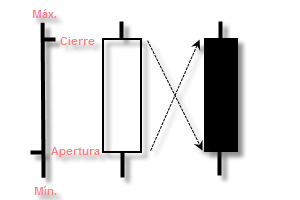
 
Además de los precios de apertura, máximo, mínino y cierre, también suelen presentarse, sean en forma gráfica o en forma de tabla, los datos de Volumen y el Precio Promedio Ponderado por Volumen. 

A pesar de que las barras o velas temporales son quizás la forma más popular de representar datos financieros entre practicantes y académicos, no son la forma más eficiente de presentar lo datos, al menos por dos razones. En primer lugar, los mercados no procesan la información a intervalos de tiempo constante. La hora siguiente a la apertura de un mercado es mucho más activa que una hora cerca del mediodía. Esto trae como resultado que las barras, o velas, basadas en intervalos de tiempo fijo, sobre muestrean la información en períodos de poca actividad y sub-muestrean la información durante períodos de baja actividad. En segundo lugar, las series de datos muestreadas en función del tiempo por lo general tiene muy malas características estadísticas, tales como correlación lineal, heteroscedasticidad (cuando la varianza no es constante) y retornos con distribuciones no-normales. Entonces, ¿qué podemos hacer para evitar este tipo de problemas? Pues aquí es donde entran las barras basadas en información. Sin embargo, antes de que nos adentremos en este tipo de barras (lo vamos a hacer en el artículo siguiente) debemos entender que afín de evitar el problema base, necesitamos contar con datos del mercado que no estén segados por un determinado período de tiempo en su formato de presentación. En lugar de ellos, nos interesa obtener los datos de cada operación que se vaya ejecutando en el mercado justo en el tiempo que fue ejecutada. A este tipo de datos se les llama “datos tick”. Los datos tick hacen referencia a cualquier información de mercado que muestre el precio y el volumen de cada operación realizada.

Si, al igual que yo, han intentado conseguir datos tick en la red, seguramente se habrán encontrado con una serie de muros que impiden el acceso libre a este tipo de datos. Y sin acceso a datos tick se limita mucho nuestra capacidad obtener patrones que explotar. ¿Por qué es difícil obtener datos tick? Entre otras razones porque son mucho más pesados y requieren de accesos especiales a los Exchanges, además de que debemos contar con los algoritmos que procesen los mensajes de los protocolos de dichos Exchanges. Claro que, vas a encontrar muchas páginas que te ofrecen datos tick de diversos tipos de mercado, como por ejemplo: Tick Data o Quandl. Pero, el acceso a sus datos es costo, pudiendo rondar los 1000USD por activo, para un período de unos 5 años. 

Así que vamos a acabar con esta miseria. Gracias a nuestro amigo “la cadena de bloques”, ahora contamos con acceso a millones de datos tick de los mercados de criptomonedas que podemos utilizar para desarrollar nuestros algoritmos. Y los mejor de todo es que son totalmente gratuitos y al alcance de tu mano. Veamos cómo utilizar el API de Bitmex (famoso Exchange de criptomonedas) para obtener datos en resolución tick de Bitcoin.




## Cargemos las bibliotecas necesarias

Lo primero que debemos hacer el cargar las bibliotecas de python que necesitaremos para descargar los datos desde Bitmex. 

In [ ]:
# Bibliotecas necesarias
import datetime as dt
import numpy as np
import pandas as pd
from datetime import datetime
import tables as tb
import requests
import os
import gzip
from io import StringIO
import simpleaudio as sa

%matplotlib inline

## Obtención de datos
La siguiente celda de código obtiene los datos a resolución Tick de Bitcoin provistos por el exchange Bitmex. Las fechas de inicio y final indican la porción de datos a descargar.

Para crear este código me basé en los artículos de [Maks Ivanov](https://towardsdatascience.com/financial-machine-learning-part-0-bars-745897d4e4ba) y [Detlev Kerkovius](https://towardsdatascience.com/how-and-why-i-got-75gb-of-free-foreign-exchange-tick-data-9ca78f5fa26c). Al unir el contenido de ambos articulos, pude automatizar la descarga y procesamiento de los datos de Bitcoin en Bitmex. He comentado abundantemente cada porción del código para faciliar su compresión. Así, a medidas que pasees por el código encontrarás comentarios descriptivos de su funcionamiento.

### Datos de entrada:
Antes de que ejecutes la siguiente celda asegúrate de editar adecuadamente las siguientes variables:

- "start_date" -> Fecha de Inicio en formato día/mes/año - dd/MM/aaaa
- "end_data" -> Fecha Final en formato día/mes/año - dd/MM/aaaa
- "symbols" -> Símbolo de instrumentos
- "directory" -> Fichero donde se guardarán los datos

In [ ]:
# Definir fechas de inicio y final 
start_date = '7/01/2018'
end_date = '7/01/2018'

# Utilizando la biblioteca de Pandas creamos un rango 
# de fechas en el intervalos definido anteriormente
dates = pd.date_range(start=start_date, end=end_date)

# Ahora escogemos el símbolo(s) del o los activos que deseamos 
# descargar. En nuestro caso de trata de "XBTUSD"
# que es el símbolo de Bitcoin en Bitmex
symbols = ["XBTUSD"]

# Definimos el directorio donde se guardarán los datos
# a ser descargados
directory = "/carpeta/donde/guardar/los/datos/"

# Iteramos sobre los activos de la lista
for symbol in symbols:   
    # Iteramos sobre las fechas del rango de fechas
    # creados utiliando Pandas
    for date in dates:
        # Convertimos en cadenas de texto el año
        # el mes y el día.
        # Nota que el método "zfill(2)" asegura dos lugares
        # significativos en la cadena
        year = str(date.year)
        month = str(date.month).zfill(2)
        day = str(date.day).zfill(2)
        print("Símbolo:", symbol, "Año: ", year, " - Mes: ", month, " - Día: ", day)
        # Ahora vamos a apuntar a la dirección web donde están ubicados
        # los datos. Agreando el año, el mes y el día en el lugar
        # correspondiente.
        url = f"https://s3-eu-west-1.amazonaws.com/public.bitmex.com/data/trade/{year}{month}{day}.csv.gz"
        # Ya con la dirección correcta podemos hacer un 
        # request al servidor.
        r = requests.get(url, stream=True)
        # El request anterior nos entrega un stream de datos
        # que vamos a guardar en formato .csv.gz
        # Esto quiere decir que los datos descargados están comprimidos
        with open(f"{directory}{symbol}_{year}{month}{day}.csv.gz", 'wb') as file:
            for chunk in r.iter_content(chunk_size=1024):
                file.write(chunk)

# Ahora, verfiquemos que la cantidad de datos descargados
# corresponda a la cantidad de días en el rango de fechas.
total = 0
for symbol in symbols:
    count = 0
    for file in os.listdir(directory):
        if file[:6] == symbol:
            count+=1
    total += count
    print(f"{symbol} archivos descargados = {count} ")
print(f"\nArchivos totales descargados = {total}", "Deberían ser: ", str(len(dates)))

## Extracción y transformación de los datos
Ahora, con los comprimidos descargados debemos descomprimir los archivos y procecar su contenido para crear una DataFrame de Pandas que sea fácil de manipular. Luego, haremos la persistencia de los datos utilizando un archivo hdf5, que ha demostrado ser más eficiente que otras opciones, como pickle.

Enen la siguiente celda se extraen los datos comprimidos y se guardan en un archivo hdf5
### Los datos de entrada son:
- "directory" -> Carpeta donde están los datos comprimidos
- "hdf5_file" -> Nombre de archivo donde se guardarán los datos

In [ ]:
# Definamos, primeramente, la carpeta donde de encuentran los
# archivos comprimidos y tambien el nombre del archivo .h5
# que servirá como base de datos.

directory = "/carpeta/donde/guardar/los/datos/"
hdf5_file = '/carpeta/donde/guardar/los/datos/database.h5'

# Iteramos sobre cada archiov 
for file in os.listdir(directory):
    # Verificamos que se trate de un archivo comprimido
    if file.endswith('.gz'):
        print(f"\nExtrayendo: {file}")
        
        # Extraemos el arcivo gzip y lo guardamos en la base
        # de datos
        codec = 'utf-8'
        f = gzip.GzipFile(f'{directory}{file}')
        data = f.read()
        data_str = data.decode(codec)
        data_pd = pd.read_csv(StringIO(data_str))

        # El formato de la fecha en los datos originales
        # no es totalmente compatible con Pandas, así que
        # mapeamos su contenido para que corresponda con 
        # el formato desdeado
        data_pd['DateTime'] = data_pd.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))
        
        # Asignamos la columna DateTime como índice
        data_pd.set_index('DateTime', inplace=True)
        
        # Ahora vamos a desechar las columnas que no nesecitamos
        # para optiminar el tañano de la base de datos
        data_pd = data_pd.drop(columns=["timestamp", "side", "size", "tickDirection", "trdMatchID", "grossValue"])
        
        # Por comodidad, voy a cambiar el nombre de las
        # columnas de Pandas DataFrame
        data_pd.columns = ["Symbol", "Price", "Volume", "Dollar"]
        
        # Pueden haber datos de otros símbolos. 
        # Para depurar los datos, solo nos quedarmos con el 
        # símbolo que deseamos.
        data_pd = data_pd[data_pd["Symbol"] == "XBTUSD"]
        
        print("\nRESUMEN DE DATOS:")
        print(data_pd.info())
        
        # Cargar datos en la base de datos.
        store = pd.HDFStore(hdf5_file)
        symbol = file[:6]
        store.append(symbol, data_pd, format='t') 
        store.flush()
        print("\nH5 RESUMEN DEL GRABADO DE DATOS:")
        print(store.info()+"\n"+"-"*75)
        store.close()

#---------------------
# Creamos y reproducimos un ruido para notificar que el script se ha ejecutado.
# fuente = https://realpython.com/playing-and-recording-sound-python/#simpleaudio
#---------------------
frequency = 440  # Frecuencia de la nota 440 Hz
fs = 44100  # 44100 muestras por segundo
seconds = 3  # Duración de la nota, 3 segundos

# Generar una matriz con segundos*rata_muestreo pasos, con rango entre
# 0 y el número de segundos
t = np.linspace(0, seconds, seconds * fs, False)

# Generar una onda seno de 440 Hz
note = np.sin(frequency * t * 2 * np.pi)

# Asegurarse de que el valor está en un rango de 
# 16-bit
audio = note * (2**15 - 1) / np.max(np.abs(note))
# Convertir a datos de 16-bit
audio = audio.astype(np.int16)

# Comenzar la reprodución
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Esperar a que la reproducción finalice antes 
# de salir de la aplicación
play_obj.wait_done()

In [ ]:
df.Price.plot()